In [1]:
import wandb
import os 

os.environ['WANDB_NOTEBOOK_NAME'] = 
%env WANDB_API_KEY = 

wandb.login()

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/alex/Documents/new try/Lung Unet/compare_models.ipynb.


env: WANDB_API_KEY=32ba2dfcae28d5229d9da5ea919130a28f8ab52c


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: alexander-ortlieb94 (ulm-university). Use `wandb login --relogin` to force relogin


True

In [2]:
import time
from torch.nn import BCEWithLogitsLoss
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import gc  


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.19 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
from utils import (
    save_checkpoint,
    load_checkpoint,
    check_accuracy,
    save_test_images,
    get_loaders,
    plot_image_mask_pred,
    plot_image_mask_box_pred_box_tolerance,
    get_largest_segments_bounding_box, 
    plot_image_mask_box_pred_box,
    test_dice
)

from models import UNET
from monai.networks.nets import UNet
from train import train_epoch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def calculate_iou_over_under(model, test_image, test_mask, device="cuda"):
    x = test_image.to(device)
    preds = model(x)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    gt_box = get_largest_segments_bounding_box(test_mask)[0]
    pred_box = get_largest_segments_bounding_box(preds.cpu())[0]

    # Coordinates for the predicted box and ground truth box
    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = gt_box
    
    # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Calculate union area
    union_area = pred_area + gt_area - intersection_area
    
    # IoU calculation
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / gt_area if gt_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0
    
    return iou, overreach, underreach



In [11]:
import matplotlib.patches as patches
from copy import copy

def calculate_iou_over_under_with_tolerance(model, test_image, test_mask, tolerance, device="cuda"):
    x = test_image.to(device)
    preds = model(x)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    gt_box = get_largest_segments_bounding_box(test_mask)[0]
    pred_box = get_largest_segments_bounding_box(preds.cpu())[0]

    # Coordinates for the predicted box and ground truth box
    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = gt_box

    # Add tolerance
    x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - tolerance, y1_pred - tolerance, x2_pred + tolerance, y2_pred + tolerance

    # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / pred_area if gt_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    rect_pred = patches.Rectangle((x1_pred, y1_pred), x2_pred - x1_pred,
                                  y2_pred - y1_pred, linewidth=4, edgecolor='orange', facecolor='none', label='predicted crop without tolerance')
    rect_mask = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0],
                                  gt_box[3] - gt_box[1], linewidth=4, edgecolor='dodgerblue', facecolor='none', label='original crop')

    axs[0].imshow(test_image[0, 0], cmap='gray')
    axs[0].set_title('X-ray image', fontsize=20)
    axs[0].axis('off')
    axs[1].imshow(test_mask[0, 0], cmap='gray')
    axs[1].set_title('Original mask', fontsize=20)
    axs[1].axis('off')
    axs[2].imshow(preds[0, 0].cpu(), cmap='gray')
    axs[2].set_title('Predicted mask', fontsize=20)
    axs[2].axis('off')

    for i in [0, 1, 2]:
        pred_rect_copy = copy(rect_pred)
        mask_rect_copy = copy(rect_mask)
        axs[i].add_patch(mask_rect_copy)
        axs[i].add_patch(pred_rect_copy)

    plt.legend(prop={'size': 20})
    plt.show()

    return overreach, underreach


In [6]:
Own_unet = UNET(in_channels=1, out_channels=1, features= [16, 32, 64, 128]).to(DEVICE)
load_checkpoint(Own_unet, f'/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_Unet_gaussian_test_10_0.5.pth.tar') #/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_Unet_gaussian_10.pth.tar')# # 
Monai_unet = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(16, 32, 64, 128), strides=(2, 2, 2), bias = False, num_res_units = 0).to(device=DEVICE)
load_checkpoint(Monai_unet, r'/home/alex/Documents/new try/Data/Lung Unet/save_states/Monai_Unet_gaussian_test_10_0.5.pth.tar')

model = Own_unet

from simulated_lung_dataset_gaussian_std import get_loaders_simulated
train_loader, test_loader, validation_loader = get_loaders_simulated(batch_size = 1, image_std= 10, noise_std_ratio= 0.5)

=> Loading checkpoint
=> Loading checkpoint


In [34]:
import torch
import nibabel as nib
import numpy as np

def save_tensor_as_nifti(tensor, filename, affine=None):
    # Ensure tensor is on CPU and detach from the computation graph
    tensor = tensor.detach().cpu().numpy()

    # Check if the tensor is 4D (e.g., (C, D, H, W)) and squeeze the channel dimension if necessary
    if tensor.ndim == 4 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # If no affine is provided, create an identity affine matrix
    if affine is None:
        affine = np.eye(4)
    
    # Create a NIfTI image
    nifti_image = nib.Nifti1Image(tensor, affine)

    # Save the NIfTI file
    nib.save(nifti_image, filename)

test_loader_iter = iter(test_loader)

image, mask = next(test_loader_iter)

save_tensor_as_nifti(image[0,0], '/home/alex/Documents/new try/Data/Lung Unet/save_states/output_image0.05.nii')

save as dicom

In [35]:
import torch
import pydicom
from pydicom.dataset import Dataset, FileDataset
import numpy as np
import datetime

def save_float_tensor_as_dicom(tensor, filename):
    # Ensure the tensor is on CPU and detach from the computation graph
    tensor = tensor.detach().cpu().numpy()

    # If the tensor has a channel dimension (e.g., (1, H, W)), squeeze it
    if tensor.ndim == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Convert the tensor to float32 if it's not already
    tensor = tensor.astype(np.float32)

    # Create a DICOM dataset
    ds = Dataset()

    # Add required DICOM metadata fields
    ds.PatientName = "Test^Patient"
    ds.PatientID = "123456"
    ds.Modality = "OT"  # OT = Other
    ds.StudyInstanceUID = "1.2.3.4"
    ds.SeriesInstanceUID = "1.2.3.4.5"
    ds.SOPInstanceUID = "1.2.3.4.5.6"
    ds.SOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    ds.StudyDate = datetime.datetime.now().strftime('%Y%m%d')
    ds.StudyTime = datetime.datetime.now().strftime('%H%M%S')
    
    # Set image pixel data (float32 data)
    ds.Rows, ds.Columns = tensor.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 32  # 32 bits for float32
    ds.BitsStored = 32
    ds.HighBit = 31
    ds.PixelRepresentation = 0  # Unsigned data
    ds.PixelData = tensor.tobytes()  # Convert float32 array to raw bytes
    # Set the required DICOM attributes to avoid the error
    ds.is_little_endian = True  # Set to True for little-endian encoding
    ds.is_implicit_VR = True 
    # Save the DICOM file
    ds.save_as(filename)
    #pydicom.filewriter.dcmwrite(filename, ds)

filename = f'/home/alex/Documents/new try/Data/Lung Unet/save_states/output_image0.1.dcm'

save_float_tensor_as_dicom(image[0,0], filename)

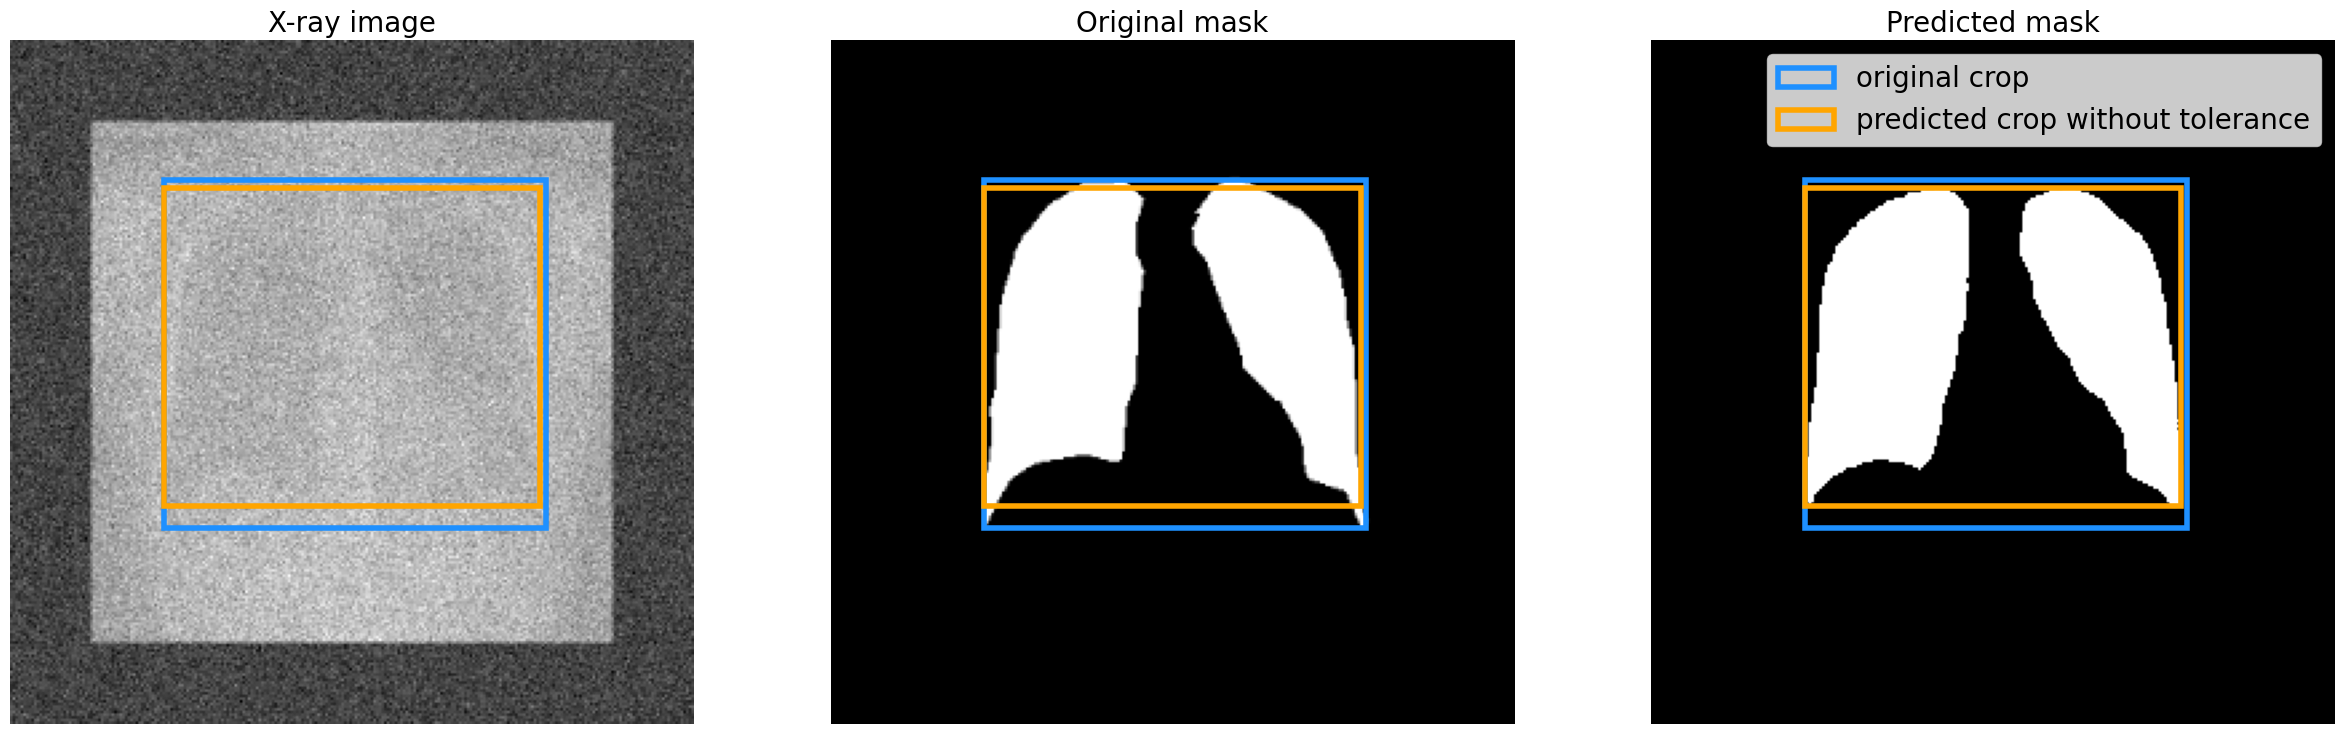

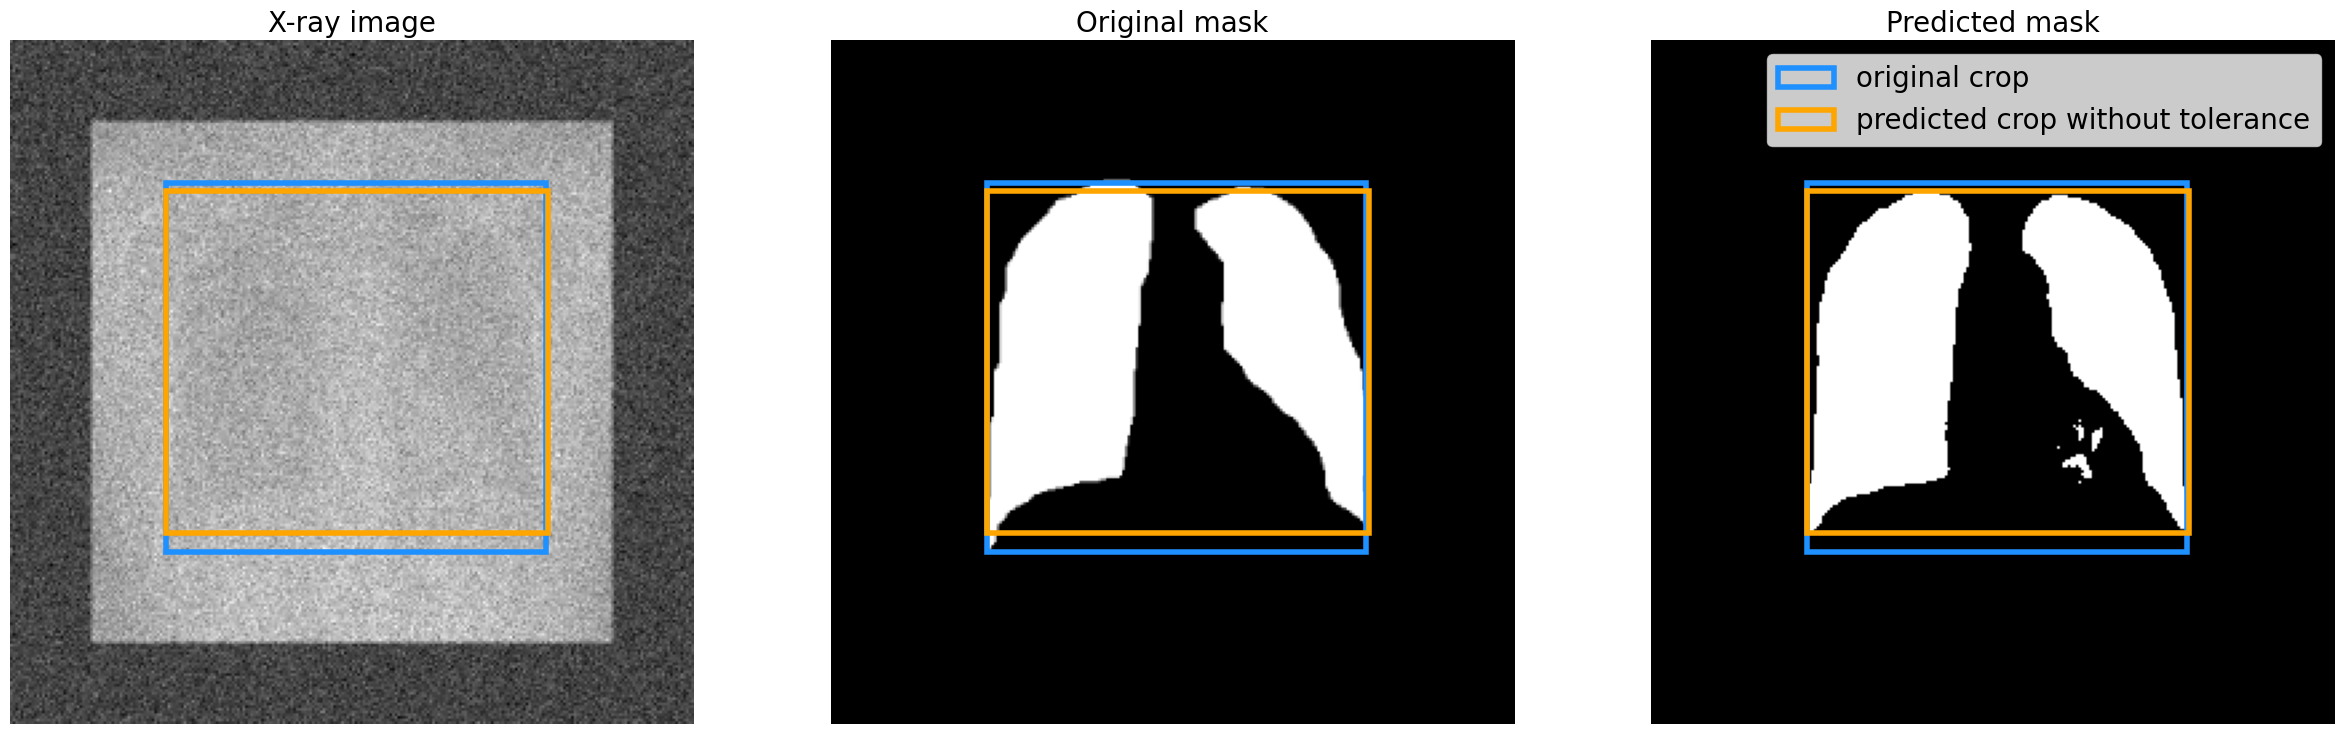

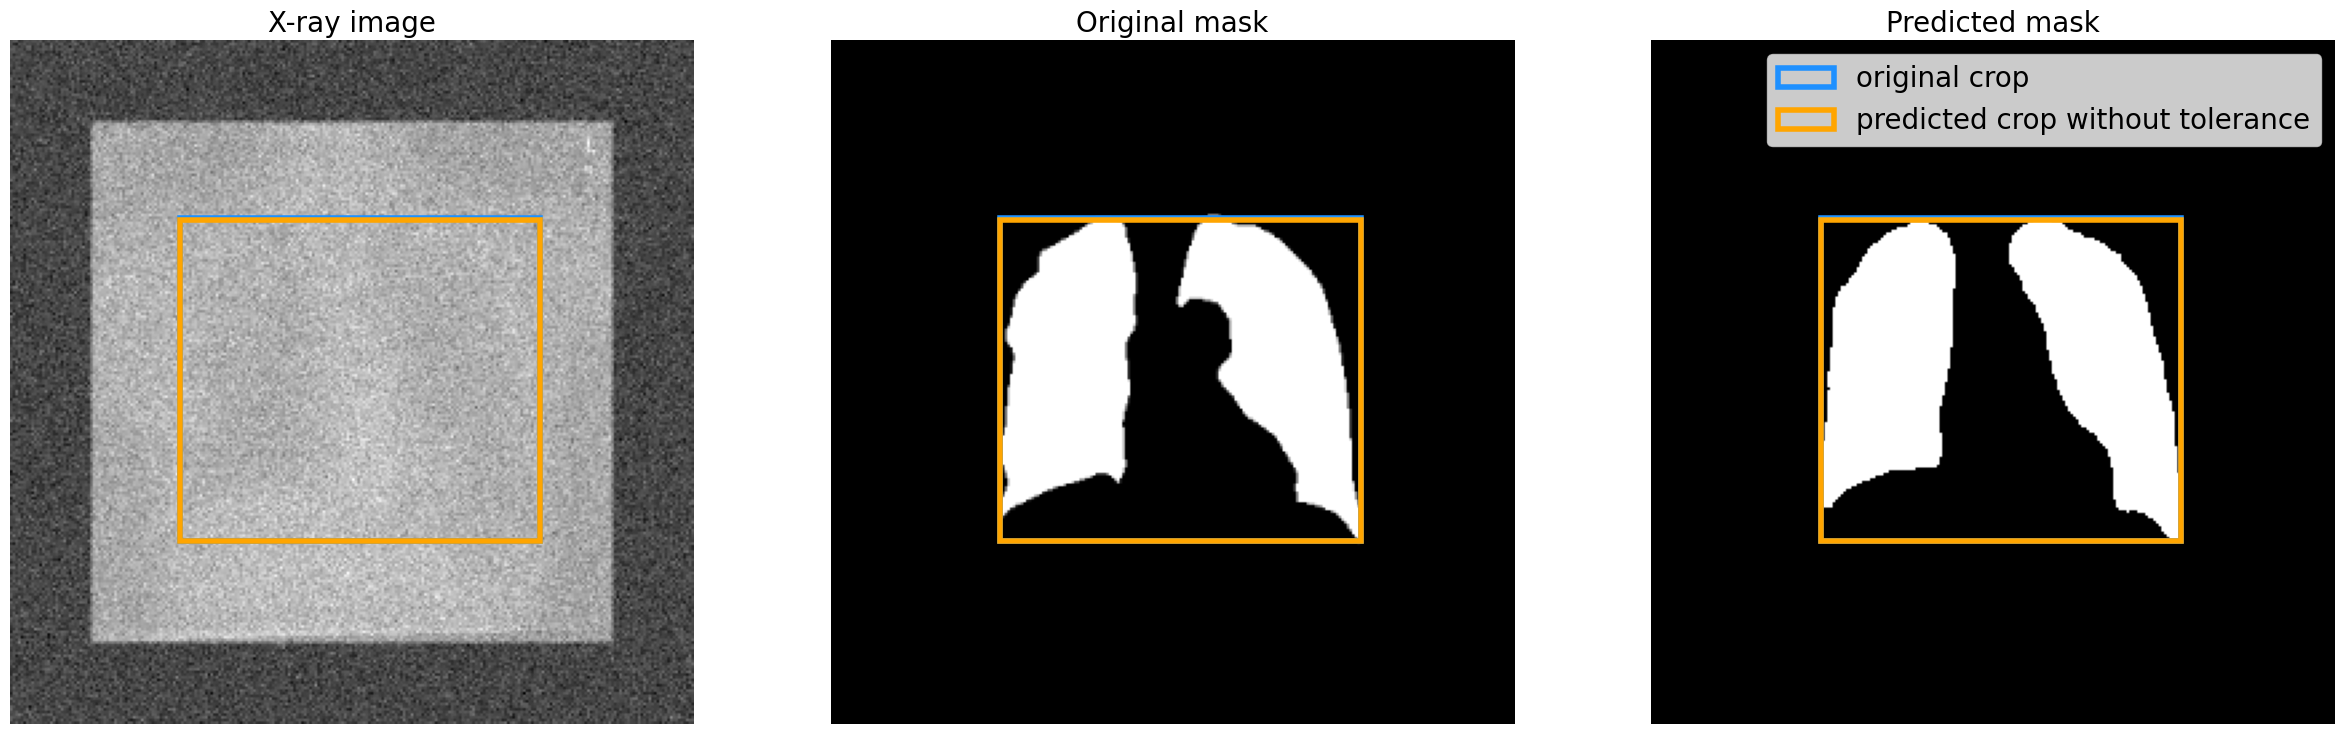

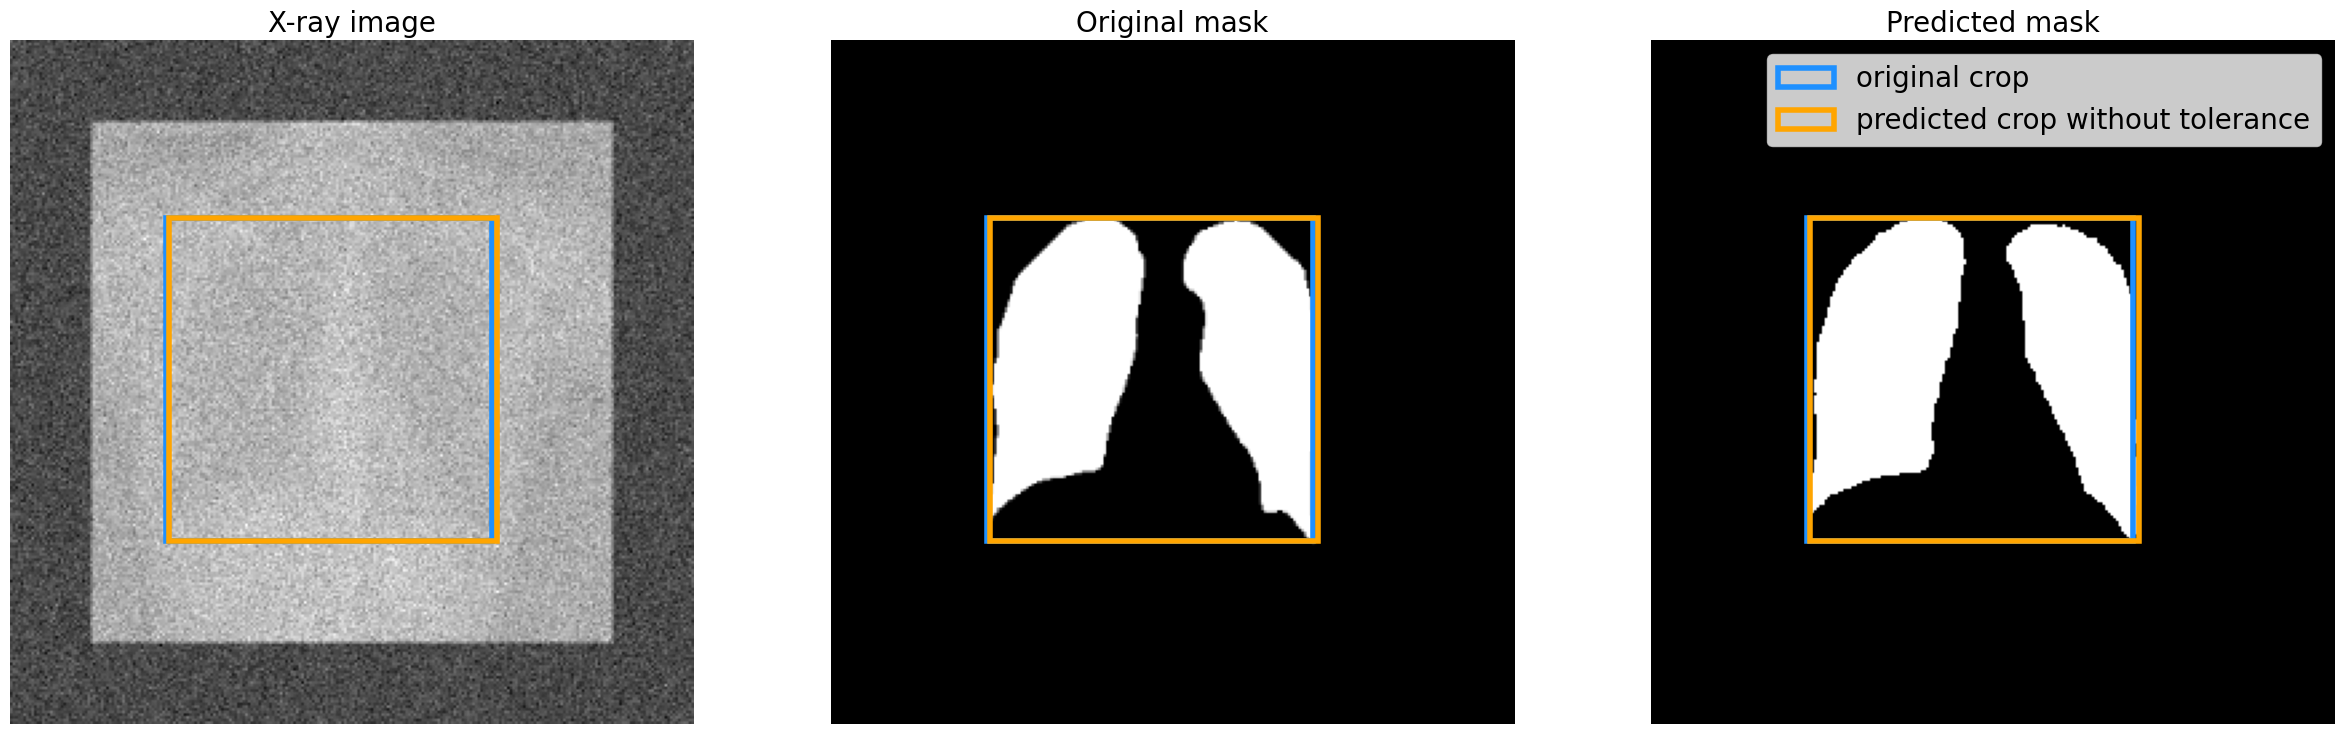

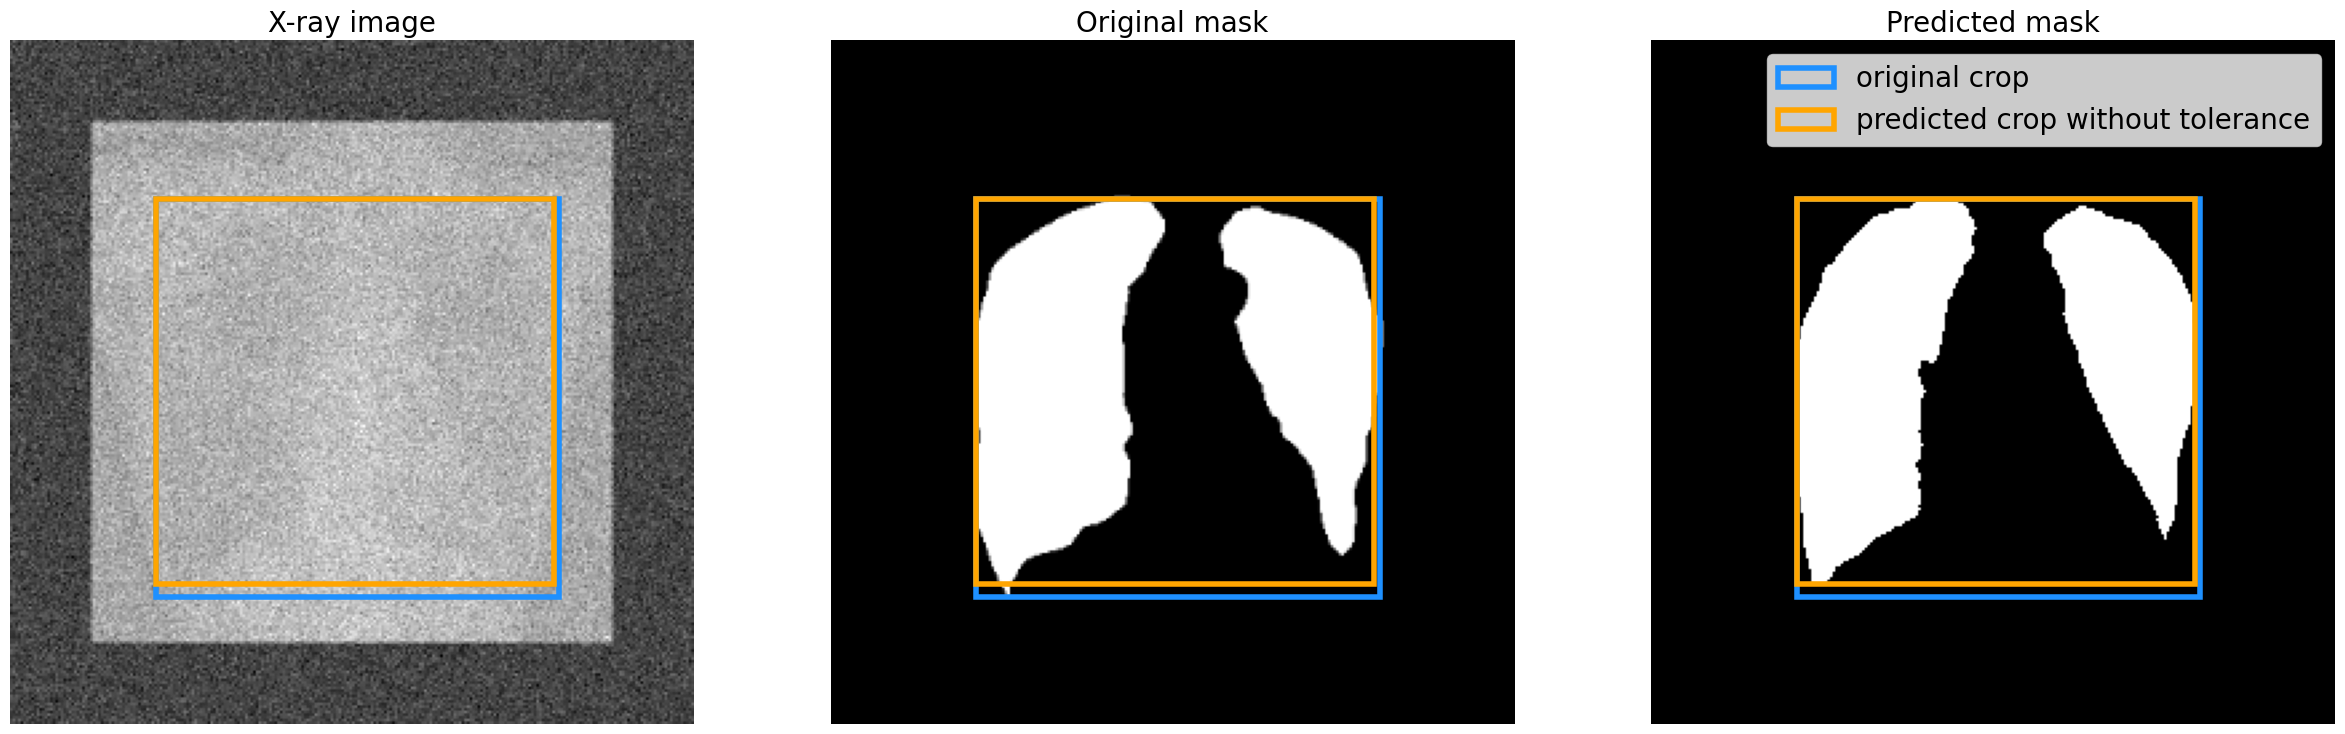

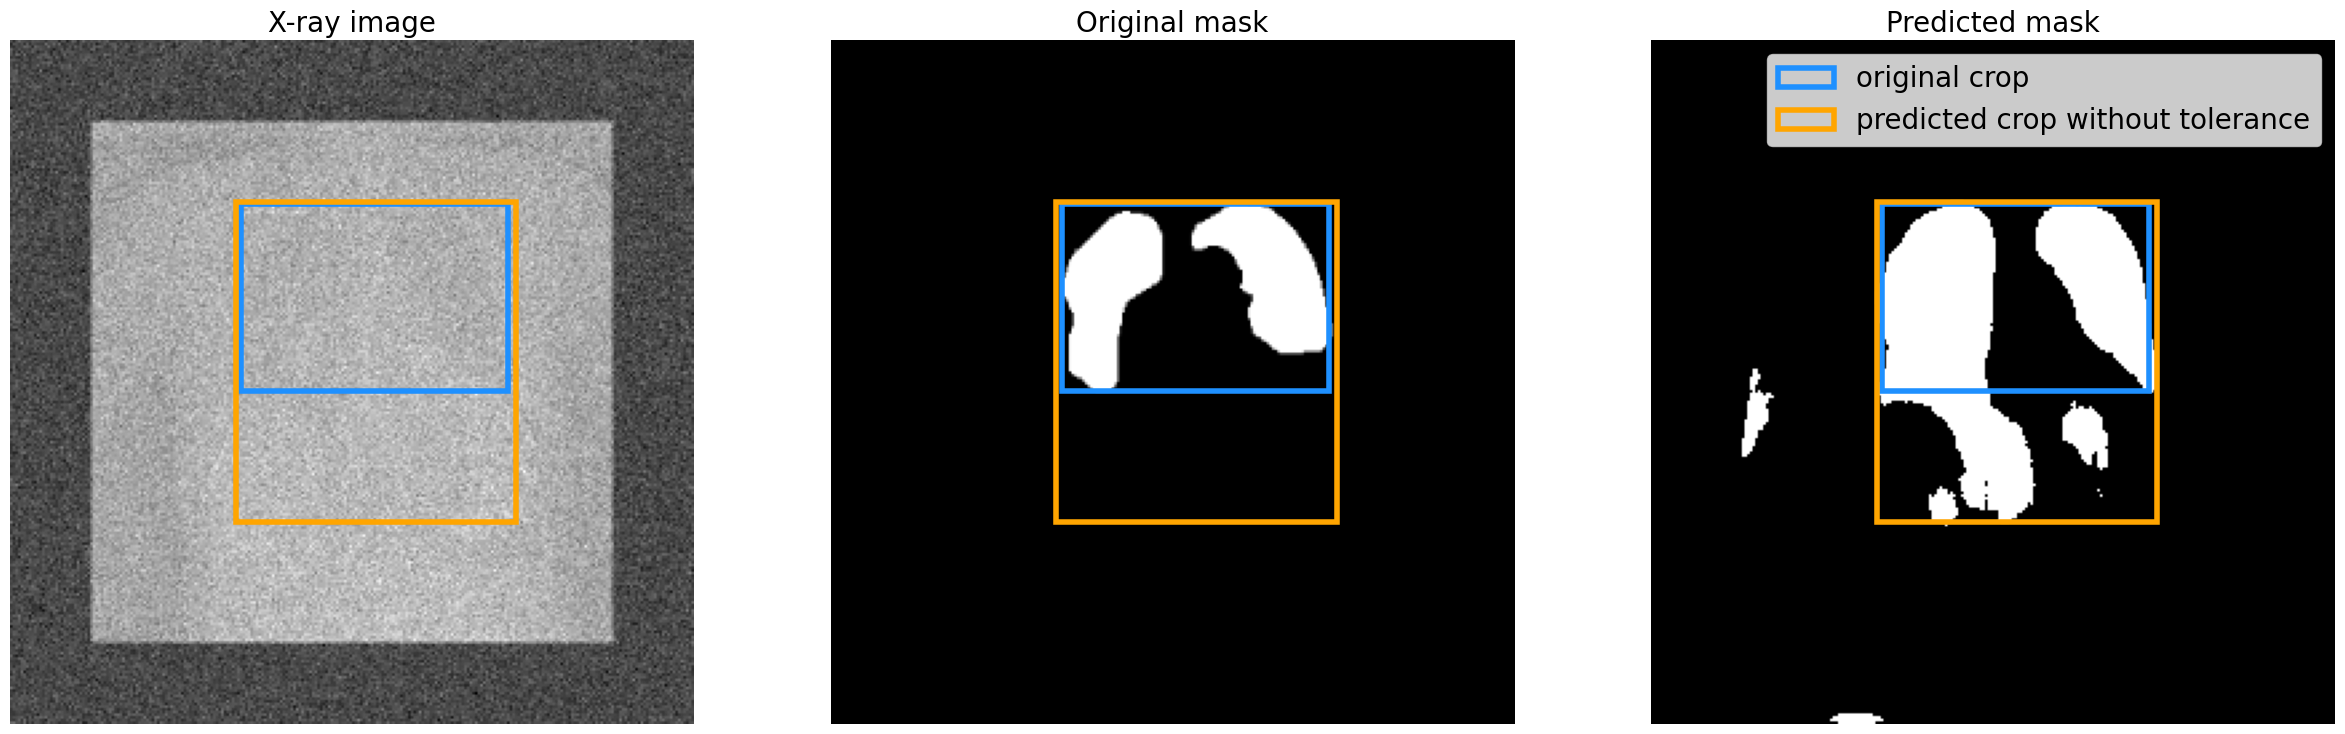

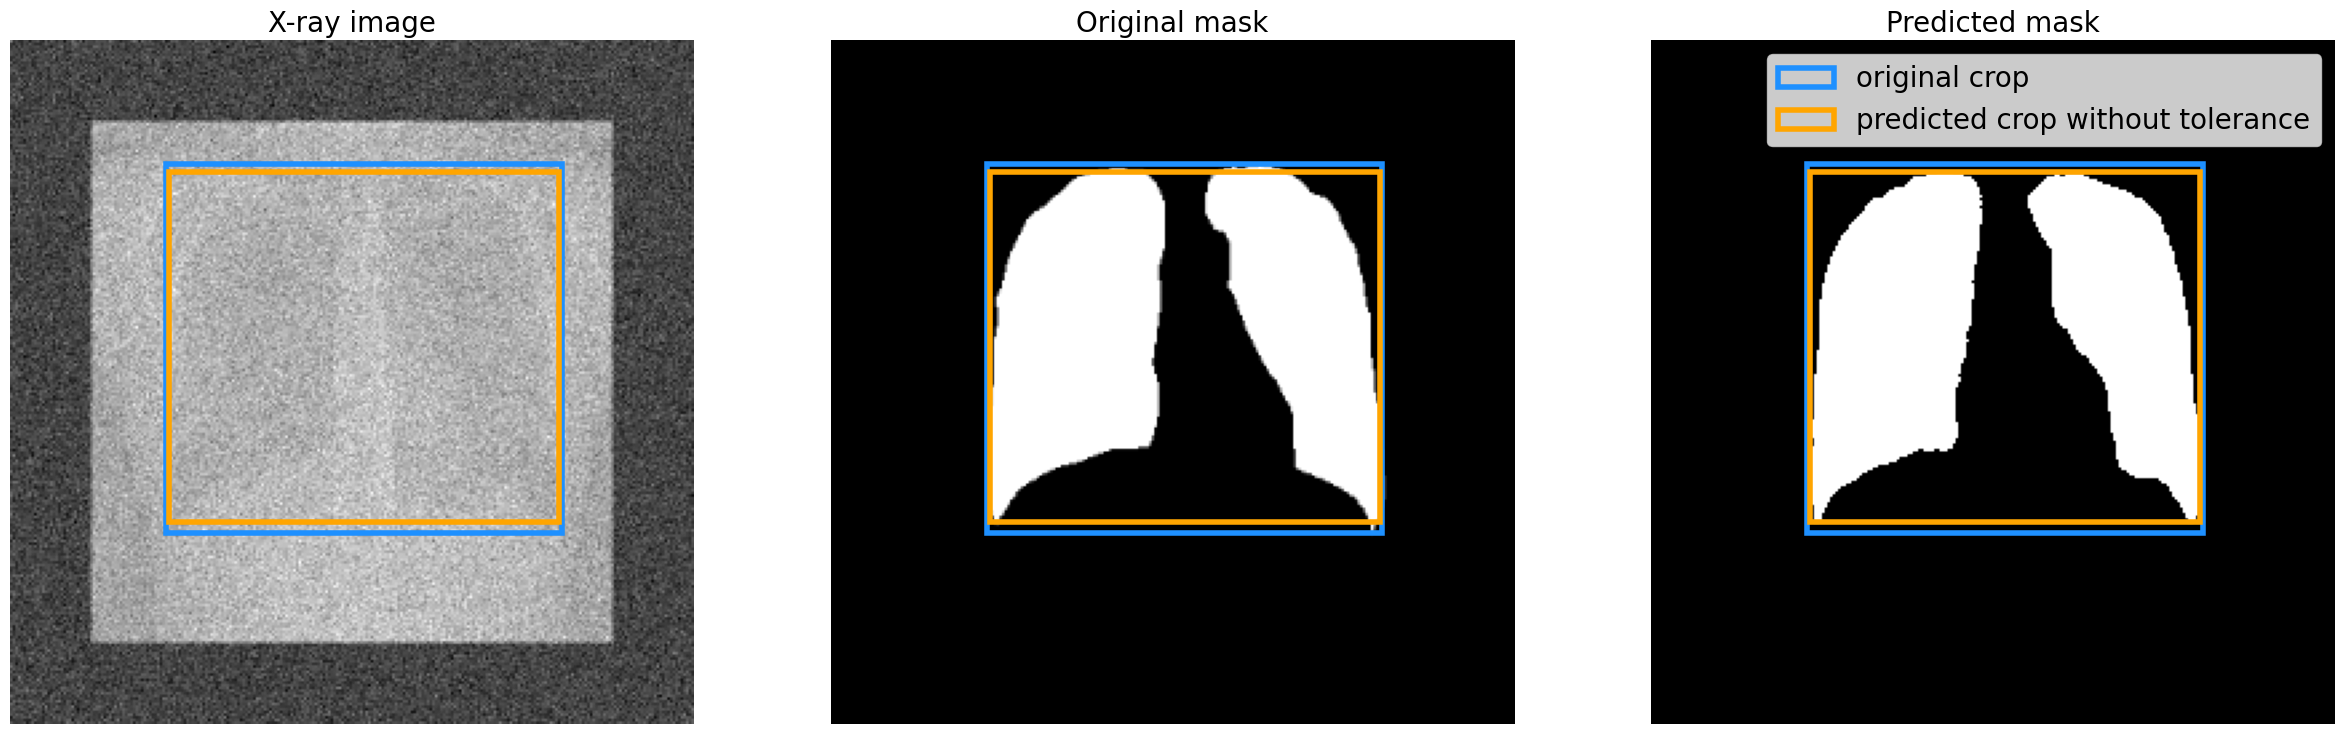

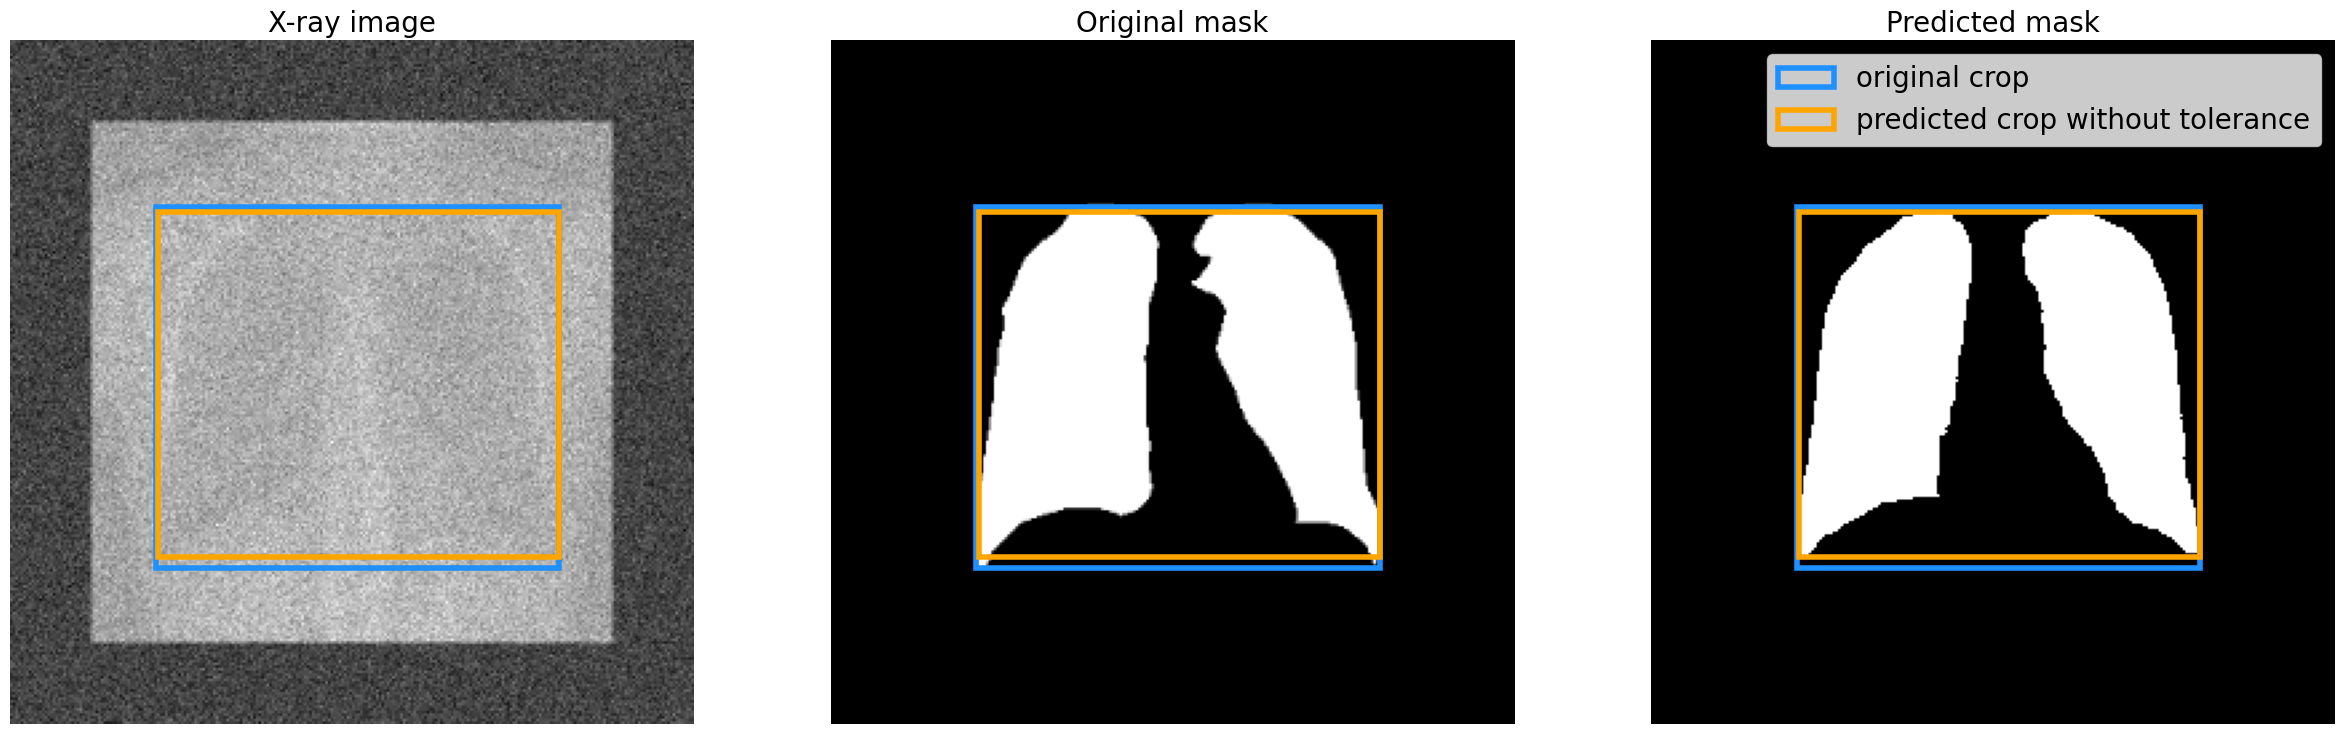

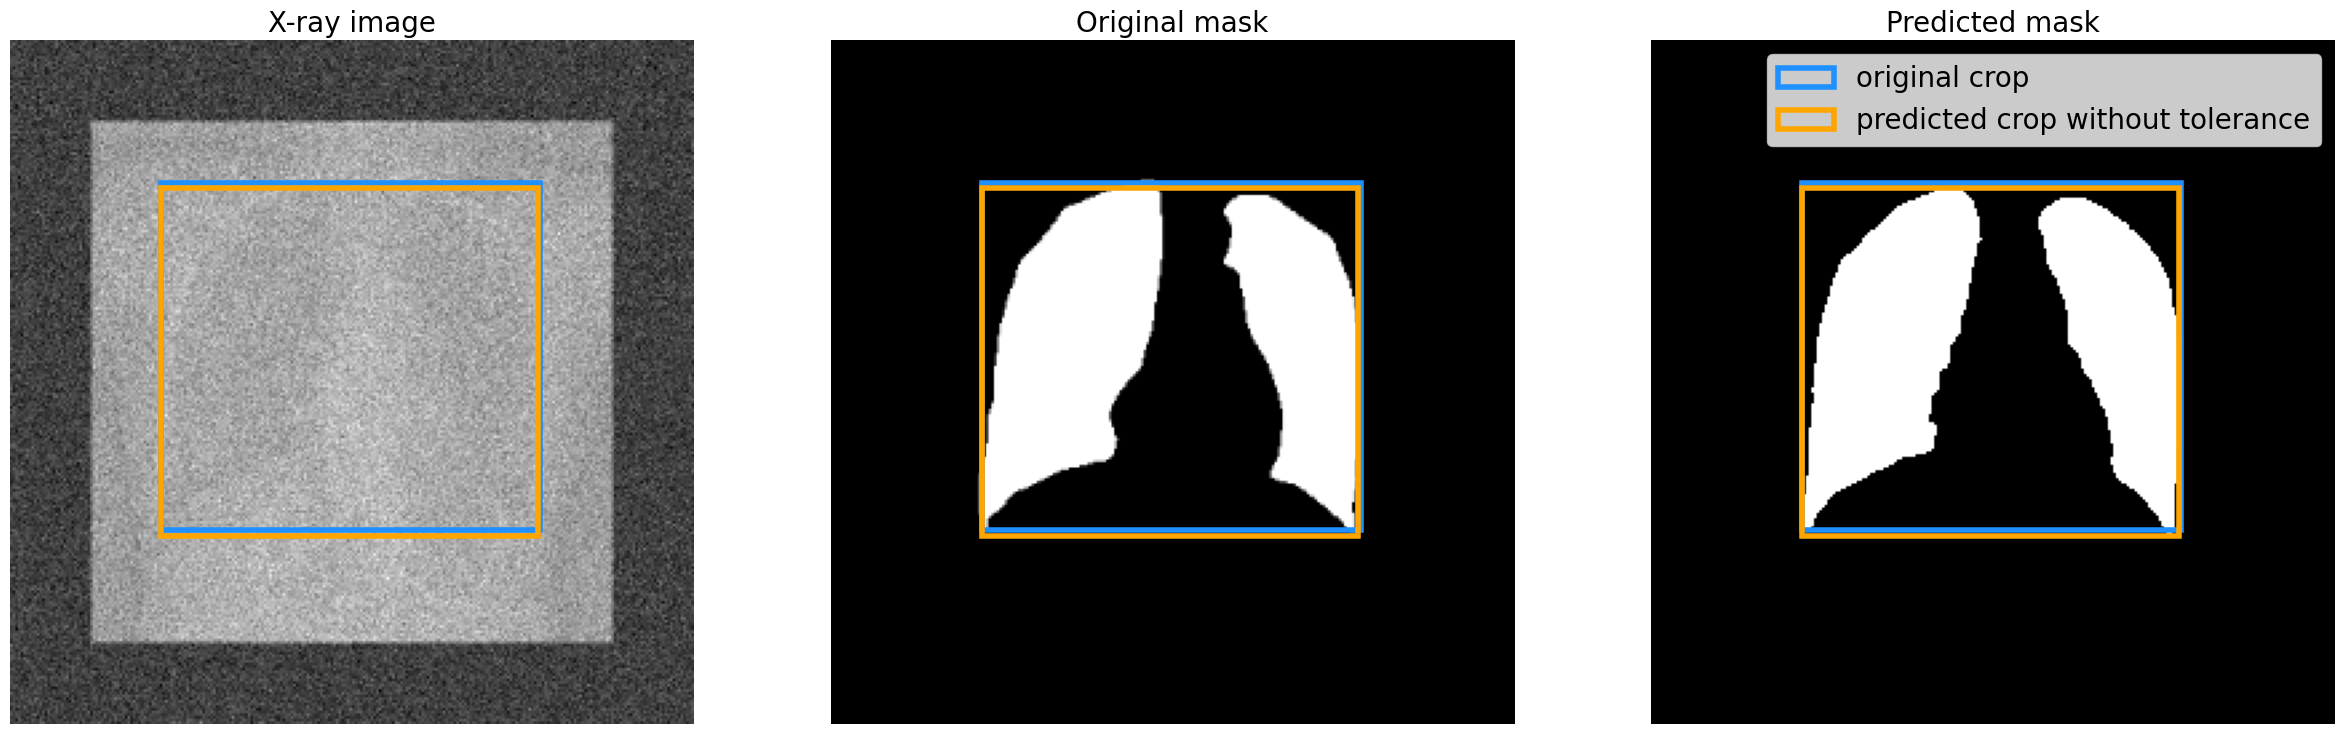

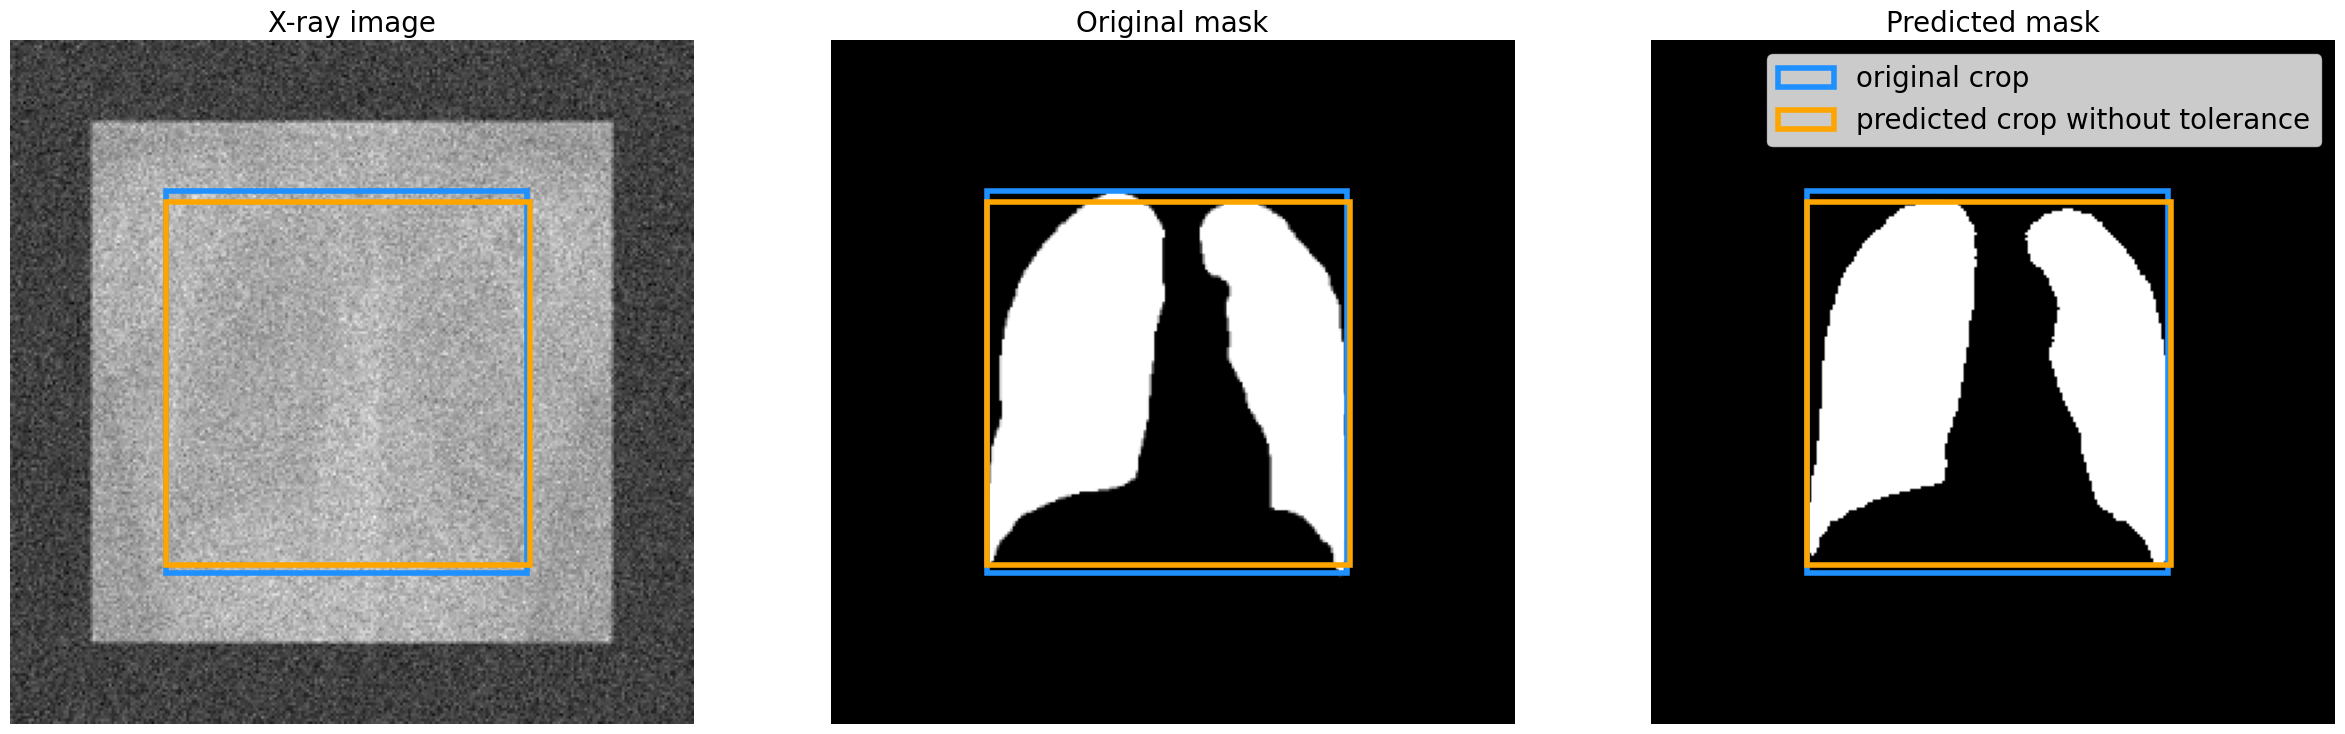

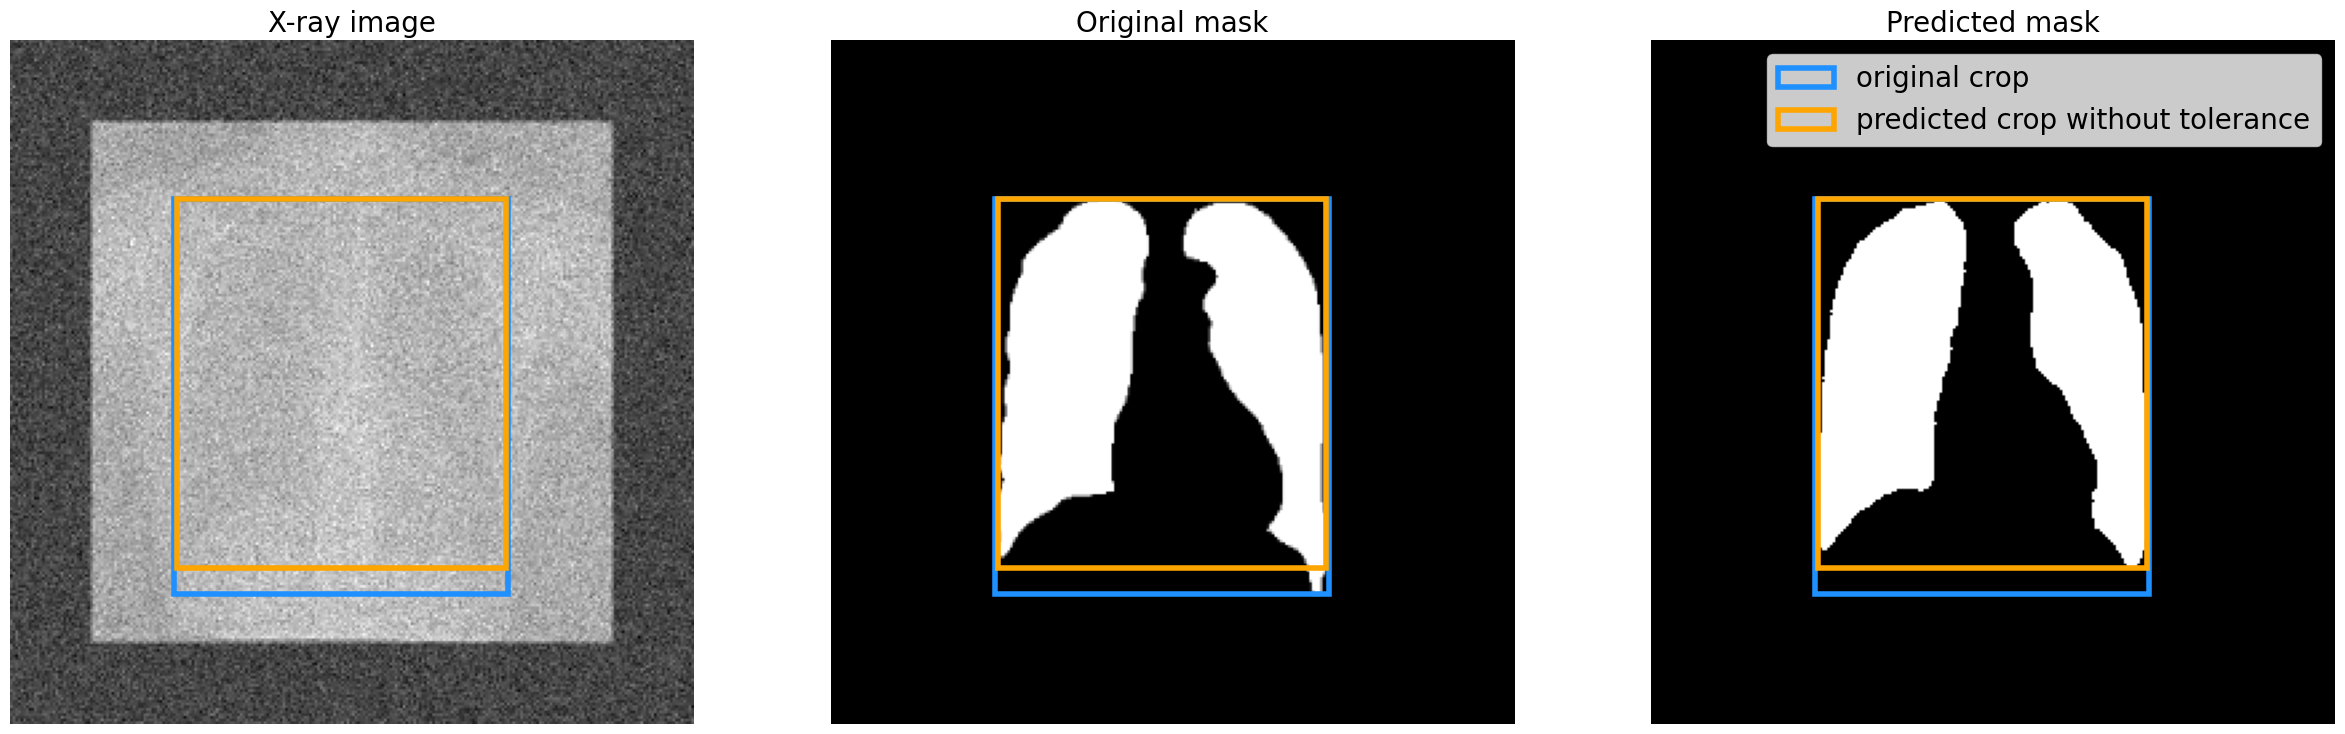

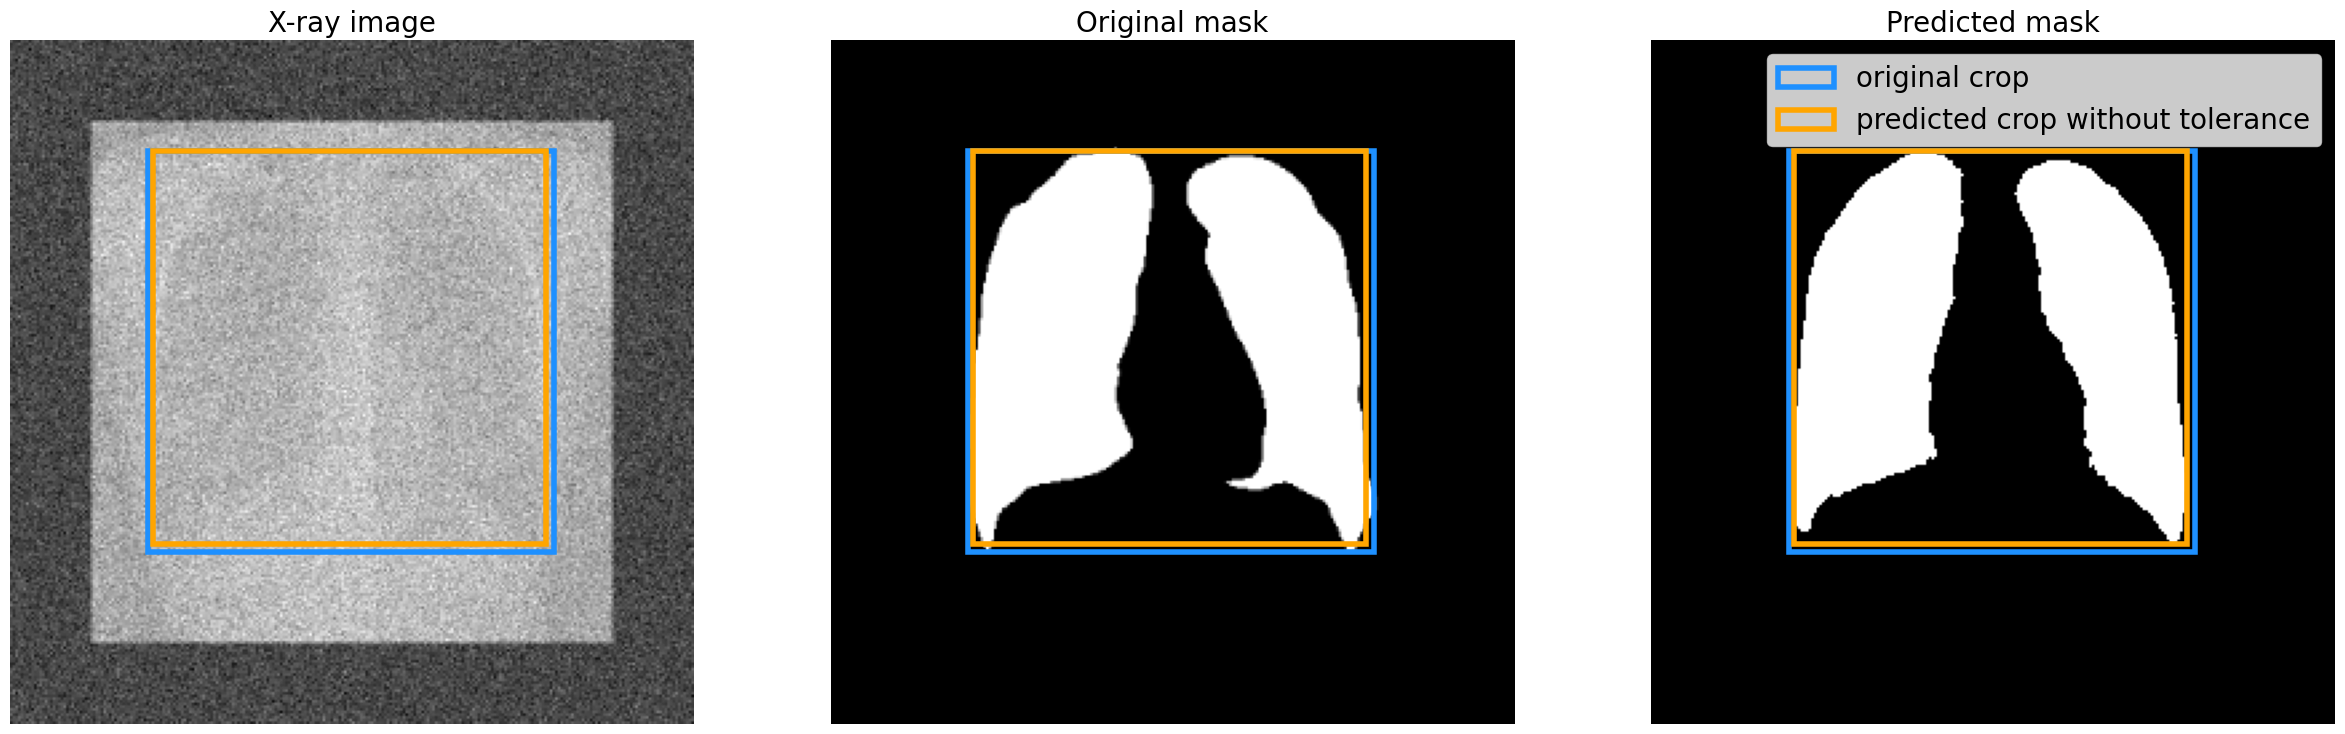

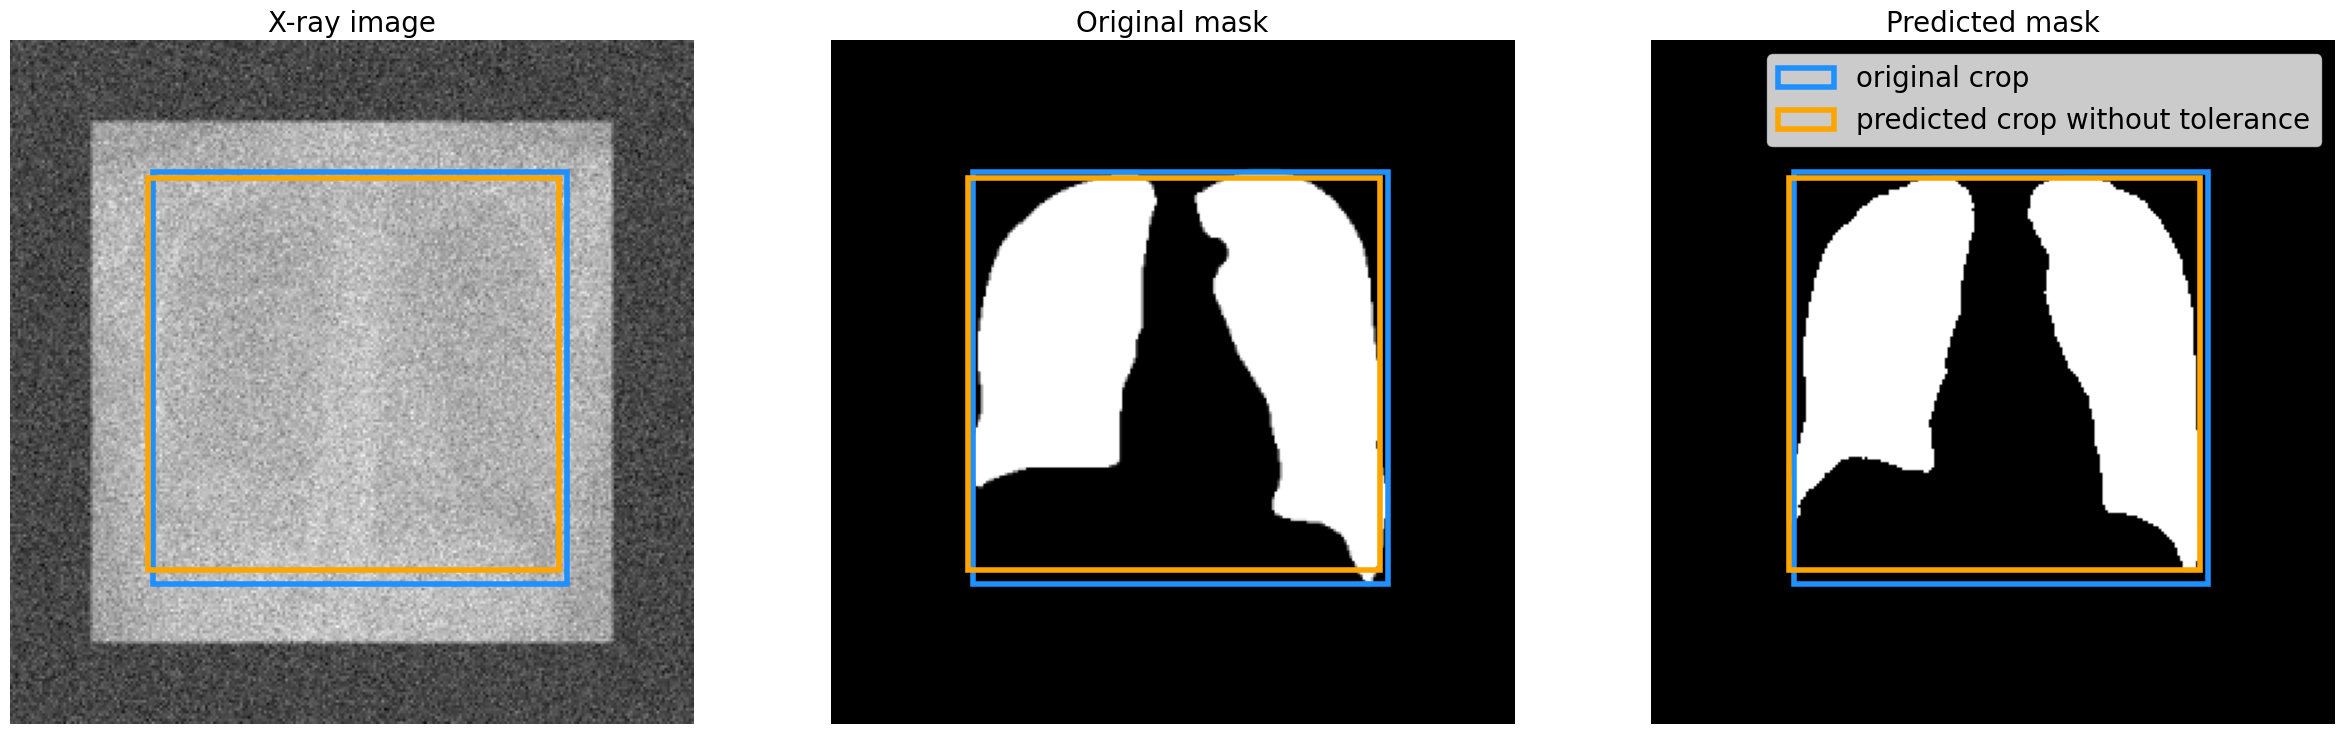

KeyboardInterrupt: 

In [12]:
#test_loader_iter = iter(test_loader)

for image, mask in test_loader:

    overreach, underreach = calculate_iou_over_under_with_tolerance(model, image, mask, tolerance=0, device="cuda")

#test_dice(test_loader, Own_unet, device=DEVICE)
#print(f"Overreach: {overreach:.3f}, Underreach: {underreach:.3f}")

#fig = plot_image_mask_box_pred_box_tolerance(model, image, mask, 10, device="cuda")
#image_mask_over_under(Monai_unet, image, mask, device="cuda")


In [8]:
import torch
from PIL import Image

for image, maske in test_loader:
    tensor = image.detach().cpu()
    # Normalize tensor to the range [0, 255] if necessary
    if tensor.min() < 0 or tensor.max() > 1:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    tensor = (tensor * 255).byte()  # Convert to 8-bit pixel values

    image = Image.fromarray(tensor[0,0].numpy(), mode='L')
    image.save(f'/home/alex/Documents/new try/Data/Lung Unet/save_states/test_image_0.5nosie.png')
    break

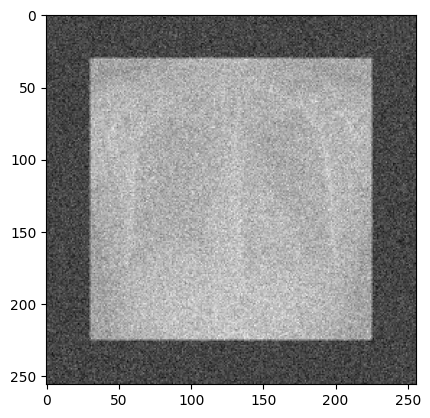

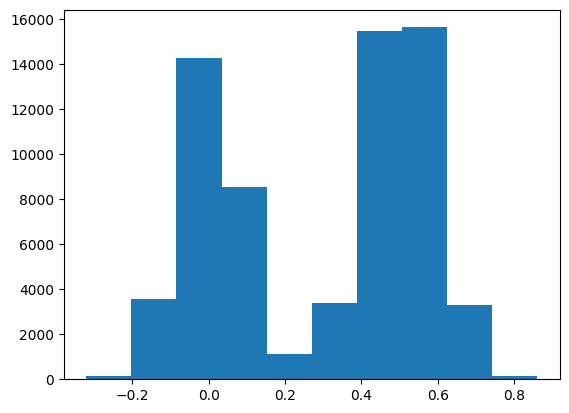

In [20]:
plt.imshow(image[0,0], cmap = 'gray')
plt.show()
plt.hist(image[0,0].flatten())
plt.show()

In [21]:
ious, overreachs, underreachs = [], [], []
tolerance = 0

#load_checkpoint(Monai_unet, f'/home/alex/Documents/new try/Data/Lung Unet/save_states/simulate_data/Monai_Unet_gaussian5.pth.tar')
sum_maks, sum_image = 0, 0
for image, mask in test_loader:
    #overreach, underreach = calculate_iou_over_under_with_tolerance(model, image, mask, tolerance=tolerance, device="cuda")
    #overreachs.append(overreach)
    #underreachs.append(underreach)
    sum_maks += (mask == 1).sum()
    sum_image += 256*256

1 - sum_maks / sum_image

tensor(0.8480)

In [ ]:
overreachs = 100* np.array(overreachs)
underreachs = 100*np.array(underreachs)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(overreachs, bins = 50)#, range = (0, 0.5))
axs[0].set_title('Overreach', size = 16)
axs[0].set_xlabel('Overreach in %', size = 14)
axs[0].set_ylabel('Number of images', size = 14)
axs[0].tick_params(axis='both', labelsize=14)
axs[1].hist(underreachs, bins = 50)#, range = (0, 0.5))
axs[1].set_title('Underreach', size = 16)
axs[1].set_xlabel('Underreach in %', size = 14)
axs[1].set_ylabel('Number of images', size = 14)
axs[1].tick_params(axis='both', labelsize=14)
#fig.suptitle(f"EfficientNet_0 gaussian, tolerance = {tolerance}", fontsize=15)
plt.savefig(r'/home/alex/Documents/Images_thesis/EffNet_overreach_underreach_without_tolerance.png', bbox_inches="tight")
plt.show()

